In [1]:
from pathlib import Path
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
tex_fonts = {
    
    # Use LaTeX to write all text
   "text.usetex": True,
   "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
   "axes.labelsize": 14,
   "font.size": 14,

   "legend.fontsize": 12,
   "xtick.labelsize": 12,
   "ytick.labelsize": 12
}

In [3]:
plt.rcParams.update(tex_fonts) # use latex fonts

In [4]:
out = Path("out")

fig_dir = Path("fig")
fig_dir.mkdir(exist_ok=True)

In [5]:
# MAML meta-learning 10 inner GD steps, actual training aligned with 10 GD steps
ckpt_maml_10s = pickle.load(open(out / "mc_maml_10g_10g.p", "rb"))
df_maml_10g = pd.DataFrame(ckpt_maml_10s["fit"].T, columns=[str(l) for l in ckpt_maml_10s["train_lens"]])
df_maml_10g = df_maml_10g.melt(var_name="length", value_name="fit")
df_maml_10g.insert(0, "model", "maml_10g")

In [6]:
# MAML meta-learning 10 inner SGD steps, actual training with 10000 AdamW steps
ckpt_maml_10000a = pickle.load(open(out / "mc_maml_10g_10000a.p", "rb"))
df_maml_10000a = pd.DataFrame(ckpt_maml_10000a["fit"].T, columns=[str(l) for l in ckpt_maml_10000a["train_lens"]])
df_maml_10000a = df_maml_10000a.melt(var_name="length", value_name="fit")
df_maml_10000a.insert(0, "model", "maml_10000a")

In [7]:
ckpt_red_20 = pickle.load(open(out / "mc_red.p", "rb"))
df_red_20 = pd.DataFrame(ckpt_red_20["fit"].T, columns=[str(l) for l in ckpt_red_20["train_lens"]])
df_red_20 = df_red_20.melt(var_name="length", value_name="fit")
df_red_20.insert(0, "model", "reduced 20")

In [8]:
ckpt_red_10 = pickle.load(open(out / "mc_red_10.p", "rb"))
df_red_10 = pd.DataFrame(ckpt_red_10["fit"].T, columns=[str(l) for l in ckpt_red_10["train_lens"]])
df_red_10 = df_red_10.melt(var_name="length", value_name="fit")
df_red_10.insert(0, "model", "reduced 10")

In [9]:
ckpt_full = pickle.load(open(out / "mc_full.p", "rb"))
df_full = pd.DataFrame(ckpt_full["fit_bfgs"].T, columns=[str(l) for l in ckpt_full["train_lens"]])
df_full = df_full.melt(var_name="length", value_name="fit")

In [10]:
ckpt_full = pickle.load(open(out / "mc_full.p", "rb"))

df_full = pd.DataFrame(ckpt_full["fit_bfgs"].T, columns=[str(l) for l in ckpt_full["train_lens"]])
df_full = df_full.melt(var_name="length", value_name="fit")
df_full.insert(0, "model", "full (bfgs)")

In [11]:
df_mc = pd.concat((df_full, df_red_20, df_red_10, df_maml_10000a, df_maml_10g), ignore_index=True)

In [12]:
rms_y = 66.69 # 1e5 rmse of y 
fit_lin = 77.17 # fit of a linear baseline obtained with MATLAB's sysid toolbox
rmse_lin = (1 - fit_lin/100.0) * rms_y # rmse of a linear baseline

In [13]:
df_mc["fit"] = np.maximum(df_mc["fit"], 0.0)
df_mc["rmse"] = (1 - df_mc["fit"]/100.0) * rms_y

In [14]:
df_mc = df_mc[df_mc["length"].isin(["100", "200", "400", "500", "600", "800", "1000", "2000", "3000", "4000", "5000"])]
df_mc["length"] = df_mc["length"].astype(int)
df_mc.sort_values(by=["model", "length"], inplace=True)

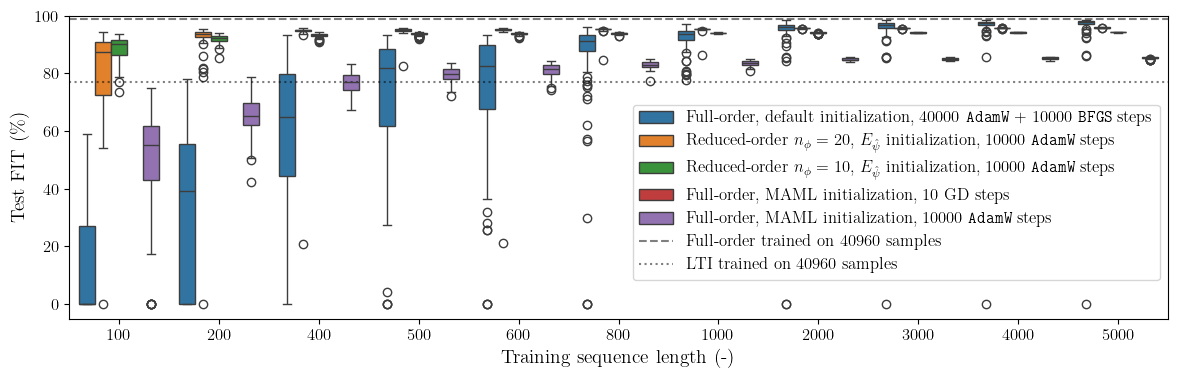

In [15]:
model_labels = {
    "full (bfgs)": r"Full-order, default initialization, 40000 \texttt{AdamW} + 10000 \texttt{BFGS} steps",
    "reduced 20": r"Reduced-order $n_\phi=20$, $E_{\hat \psi}$ initialization, 10000 \texttt{AdamW} steps",
    "reduced 10": r"Reduced-order  $n_\phi=10$, $E_{\hat \psi}$ initialization, 10000 \texttt{AdamW} steps",
    "maml_10h": r"Full-order, MAML initialization, 10 GD steps",
    "maml_10000a": r"Full-order, MAML initialization, 10000 \texttt{AdamW} steps"
}
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax = sns.boxplot(df_mc, x="length", y="fit", hue=df_mc["model"].map(model_labels), hue_order=model_labels.values(), ax=ax)
ax.axhline(y=98.9, color="black", linestyle="dashed", alpha=0.5, label="Full-order trained on 40960 samples")#, linewidth=0.5)
ax.axhline(y=fit_lin, color="black", linestyle="dotted", alpha=0.5, label="LTI trained on 40960 samples")#, linewidth=0.5)

#plt.xticks(rotation=45)
ax.set_xlabel(r"Training sequence length (-)")
ax.set_ylabel(r"Test FIT (\%)")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.1))
plt.ylim([-5, 100]);
plt.tight_layout()

plt.savefig(fig_dir/"boxplot_paper.pdf")

In [19]:
df_stats = df_mc.groupby(["model", "length"]).agg(["mean", "median", "std"])

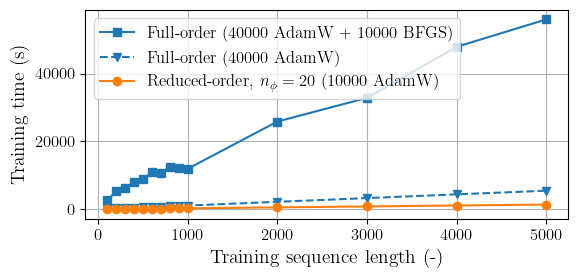

In [18]:
# computational time
plt.figure(figsize=(6,3))
#plt.title("Training time")
plt.plot(ckpt_full["train_lens"], ckpt_full["train_time"], label="Full-order (40000 AdamW + 10000 BFGS)", marker="s", color="C0")
plt.plot(ckpt_full["train_lens"], ckpt_full["train_time_adam"], label="Full-order (40000 AdamW)", marker="v", linestyle="--", color="C0")
plt.plot(ckpt_red_20["train_lens"], ckpt_red_20["train_time"], label=r"Reduced-order, $n_\phi=20$ (10000 AdamW)", marker="o", color="C1")
plt.xlabel("Training sequence length (-)")
plt.ylabel("Training time (s)")
plt.grid(True)
plt.legend();
plt.tight_layout()
plt.savefig(fig_dir/"training_times_paper.pdf")